In [1]:
%load_ext autoreload  
%autoreload 2  
!hostname  
!pwd  
import os
import sys

print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "4"

isola-v100-2.csail.mit.edu
/data/vision/phillipi/akumar01/synthetic-mdps/src
/data/vision/phillipi/akumar01/.virtualenvs/synthetic-mdps/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial  

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import jax
import jax.numpy as jnp
from jax.random import split

import flax.linen as nn
from flax.training.train_state import TrainState

import optax

In [4]:
import gymnasium as gym
import util

import data_utils

data_dir = "~/synthetic-mdps-data/"
data_dir = os.path.expanduser(data_dir)

d_obs_uni, d_act_uni = 128, 16
env_id = "Reacher-v4"

/data/vision/phillipi/akumar01/.virtualenvs/synthetic-mdps/lib/python3.10/site-packages/gym/wrappers/monitoring/video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn


In [5]:
dataset = data_utils.load_dataset(f"{data_dir}/datasets/mujoco/Reacher/dataset.pkl")
dataset_train_ori, dataset_test_ori = data_utils.train_test_split(dataset, percent_train=0.8)
del dataset
transform_params = data_utils.get_dataset_transform_params(jax.random.PRNGKey(0), dataset_train_ori,
                                                           d_obs_uni=d_obs_uni, d_act_uni=d_act_uni)

dataset_train_ori = jax.tree_map(lambda x: jnp.array(x), dataset_train_ori)
dataset_test_ori = jax.tree_map(lambda x: jnp.array(x), dataset_test_ori)
transform_params = jax.tree_map(lambda x: jnp.array(x), transform_params)

dataset_train_uni = data_utils.transform_dataset(dataset_train_ori, transform_params)
dataset_test_uni = data_utils.transform_dataset(dataset_test_ori, transform_params)
print(jax.tree_map(lambda x: (x.shape, x.dtype, type(x)), dataset_train_uni))

2024-04-08 19:13:43.906297: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


{'act': ((51, 16384, 16), dtype('float32'), <class 'jaxlib.xla_extension.ArrayImpl'>), 'done': ((51, 16384), dtype('float32'), <class 'jaxlib.xla_extension.ArrayImpl'>), 'obs': ((51, 16384, 128), dtype('float32'), <class 'jaxlib.xla_extension.ArrayImpl'>), 'rew': ((51, 16384), dtype('float32'), <class 'jaxlib.xla_extension.ArrayImpl'>), 'time': ((51, 16384), dtype('int32'), <class 'jaxlib.xla_extension.ArrayImpl'>)}


In [6]:
def sample_batch(rng, dataset, bs, ctx_len):
    _rng1, _rng2 = split(rng)
    B, T, _ = dataset['obs'].shape
    i_b = jax.random.randint(_rng1, (bs, 1), 0, B)
    i_t = jax.random.randint(_rng2, (bs, 1), 0, T - ctx_len)
    i_t = i_t + jnp.arange(ctx_len)
    return jax.tree_map(lambda x: x[i_b, i_t], dataset)

In [14]:
def make_env(env_id, idx, capture_video, run_name, gamma):
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        else:
            env = gym.make(env_id)
        env = gym.wrappers.FlattenObservation(env)  # deal with dm_control's Dict observation space
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env = gym.wrappers.ClipAction(env)
        return env

    return thunk


def get_agent_return(env_id, num_envs, n_steps, forward_fn):
    envs = gym.vector.SyncVectorEnv(
        [make_env(env_id, i, False, None, 0.99) for i in range(num_envs)]
    )
    obs, infos = envs.reset()
    stats = dict(ret=[], len=[])
    for _ in tqdm(range(n_steps), desc="Rollout"):
        obs_agent = data_utils.transform_obs(obs, transform_params)
        act_agent = forward_fn(obs_agent)
        act = data_utils.inverse_transform_act(act_agent, transform_params)
        obs, rew, term, trunc, infos = envs.step(act)

        if "final_info" in infos:
            for info in infos["final_info"]:
                if info and "episode" in info:
                    stats["ret"].append(info["episode"]["r"])
                    stats["len"].append(info["episode"]["l"])
    return dict(ret=np.array(stats["ret"]), len=np.array(stats["len"]))


def get_agent_test_loss(rng, bs, n_iters, forward_fn):
    mse_uni, mse_ori = [], []
    for _ in tqdm(range(n_iters)):
        rng, _rng = split(rng)
        batch_ori = sample_batch(_rng, dataset_test_ori, bs, 1)
        batch_ori = jax.tree_map(lambda x: x[:, 0], batch_ori)
        batch_uni = sample_batch(_rng, dataset_test_uni, bs, 1)
        batch_uni = jax.tree_map(lambda x: x[:, 0], batch_uni)
        
        act_uni_pred = forward_fn(batch_uni['obs'])
        act_ori_pred = data_utils.inverse_transform_act(act_uni_pred, transform_params)
        mse_uni_i = jnp.mean(jnp.square(act_uni_pred - batch_uni['act']))
        mse_ori_i = jnp.mean(jnp.square(act_ori_pred - batch_ori['act']))
        mse_uni.append(mse_uni_i)
        mse_ori.append(mse_ori_i)
    return jnp.stack(mse_uni).mean(), jnp.stack(mse_ori).mean()


In [16]:
a = get_agent_return(env_id, 16, 1000, lambda x: np.zeros((x.shape[0], d_act_uni)))
b = get_agent_return(env_id, 16, 1000, lambda x: np.random.normal(size=(x.shape[0], d_act_uni)))

Rollout:   0%|          | 0/1000 [00:00<?, ?it/s]

Rollout:   0%|          | 0/1000 [00:00<?, ?it/s]

In [17]:
print("Zero Agent Return: ", a['ret'].mean())
print("Randn Agent Return: ", b['ret'].mean())

Zero Agent Return:  -11.819051
Randn Agent Return:  -11.83877


# MLP BC

In [18]:
class Agent(nn.Module):
    d_obs: int
    d_act: int

    @nn.compact
    def __call__(self, x):
        act = nn.Sequential([
            nn.Dense(64),
            nn.tanh,
            nn.Dense(64),
            nn.tanh,
            nn.Dense(self.d_act, kernel_init=nn.initializers.normal(stddev=0.01)),
        ])(x)
        return act

agent = Agent(d_obs=d_obs_uni, d_act=d_act_uni)

In [19]:
def train_step(rng, train_state):
    def loss_fn(params, batch):
        act_pred = jax.vmap(agent.apply, in_axes=(None, 0))(params, batch['obs'])
        loss = jnp.mean(jnp.square(act_pred - batch['act']))
        return loss

    batch = sample_batch(rng, dataset_train_uni, bs, 1)
    batch = jax.tree_map(lambda x: x[:, 0], batch)

    grad_fn = jax.value_and_grad(loss_fn)
    loss, grad = grad_fn(train_state.params, batch)
    train_state = train_state.apply_gradients(grads=grad)
    return train_state, loss

train_step = jax.jit(train_step)

In [22]:
bs = 64
rng = jax.random.PRNGKey(0)
rng, _rng = split(rng)
batch = sample_batch(_rng, dataset_train_uni, bs, 1)
batch = jax.tree_map(lambda x: x[:, 0], batch)
agent_params = agent.init(_rng, batch['obs'][0])
tx = optax.chain(optax.clip_by_global_norm(1.), optax.adamw(3e-4, weight_decay=0., eps=1e-8))
train_state = TrainState.create(apply_fn=agent.apply, params=agent_params, tx=tx)

data = []
for i in tqdm(range(10000 + 1)):
    if i % 1000 == 0:
        rollout_data_i = get_agent_return(env_id, 16, 1000, lambda x: agent.apply(train_state.params, x))
        test_loss_data_i = get_agent_test_loss(_rng, 512, 100, lambda x: agent.apply(train_state.params, x))
        data.append([rollout_data_i['ret'].mean(), test_loss_data_i[0], test_loss_data_i[1]])
    rng, _rng = split(rng)
    train_state, loss = train_step(_rng, train_state)

  0%|          | 0/10001 [00:00<?, ?it/s]

Rollout:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Rollout:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Rollout:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Rollout:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Rollout:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Rollout:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Rollout:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Rollout:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Rollout:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Rollout:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Rollout:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [28]:
data_mlp = data
data_mlp = np.array(data_mlp)

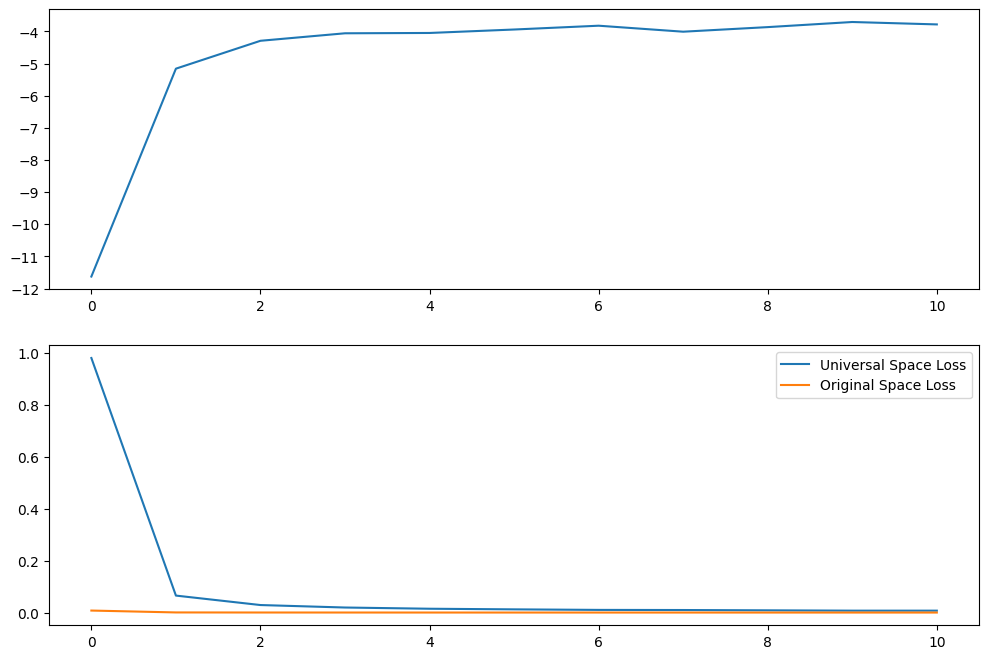

In [37]:
plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.plot(data_mlp[:, 0], label="Rollout Return")
plt.subplot(212)
plt.plot(data_mlp[:, 1], label="Universal Space Loss")
plt.plot(data_mlp[:, 2], label="Original Space Loss")
plt.legend()
plt.show()



# Transformer BC

In [38]:
from agents.regular_transformer import Block

In [48]:
class BCTransformer(nn.Module):
    d_obs: int
    d_act: int
    n_layers: int
    n_heads: int
    d_embd: int
    ctx_len: int

    mask_type: str = "causal"

    def setup(self):
        self.embed_obs = nn.Dense(features=self.d_embd)
        self.embed_act = nn.Dense(features=self.d_embd)
        self.embed_pos = nn.Embed(num_embeddings=self.ctx_len, features=self.d_embd)

        self.blocks = [Block(n_heads=self.n_heads, mask_type=self.mask_type) for _ in range(self.n_layers)]
        self.ln = nn.LayerNorm()

        self.actor = nn.Dense(features=self.d_act, kernel_init=nn.initializers.orthogonal(0.01))  # T, Da

    def __call__(self, obs, act):  # obs: (T, Do), # act: (T, Da), # time: (T, )
        assert obs.shape[0] == act.shape[0]
        assert obs.shape[0] <= self.ctx_len
        T, _ = obs.shape

        x_obs = self.embed_obs(obs)  # (T, D)
        x_act = self.embed_act(act)  # (T, D)
        x_pos = self.embed_pos(jnp.arange(T))  # (T, D)
        x_act_p = jnp.concatenate([jnp.zeros((1, self.d_embd)), x_act[:-1]], axis=0)

        x = x_obs + x_act_p + x_pos
        for block in self.blocks:
            x = block(x)
        x = self.ln(x)

        act_now_pred = self.actor(x)
        # obs_nxt_pred = self.wm(x)
        return act_now_pred

def augment_batch(rng, batch, n_augs, dist="uniform", mat_type='gaussian'):
    if n_augs == 0:
        return batch
    bs, _, d_obs = batch['obs'].shape
    bs, _, d_act = batch['act'].shape

    def augment_instance(instance, aug_id):
        rng = jax.random.PRNGKey(aug_id)
        _rng_obs, _rng_act = split(rng, 2)
        if mat_type == 'gaussian':
            obs_mat = jax.random.normal(_rng_obs, (d_obs, d_obs)) / jnp.sqrt(d_obs)
            act_mat = jax.random.normal(_rng_act, (d_act, d_act)) / jnp.sqrt(d_act)
        elif mat_type == 'orthogonal':
            obs_mat = jax.random.orthogonal(_rng_obs, d_obs)
            act_mat = jax.random.orthogonal(_rng_act, d_act)
        else:
            raise NotImplementedError
        return dict(obs=instance['obs'] @ obs_mat.T, act=instance['act'] @ act_mat.T)

    if dist == "uniform":
        aug_ids = jax.random.randint(rng, (bs,), minval=0, maxval=n_augs)
    elif dist == "zipf":
        p = 1 / jnp.arange(1, n_augs + 1)
        aug_ids = jax.random.choice(rng, jnp.arange(n_augs), (bs,), p=p / p.sum())
    else:
        raise NotImplementedError

    return jax.vmap(augment_instance)(batch, aug_ids)


In [49]:
def train_step(rng, train_state):
    def loss_fn(params, batch):
        out = jax.vmap(agent.apply, in_axes=(None, 0, 0))(params, batch['obs'], batch['act'])
        mse = jnp.mean(jnp.square(out - batch['act']), axis=(0, -1)) # mean over batch, dim
        loss = mse.mean() # mean over ctx
        metrics = dict(loss=loss, mse=mse)
        return loss, metrics
    _rng1, _rng2 = split(rng)
    batch = sample_batch(_rng1, dataset_train_uni, bs, ctx_len)
    batch = augment_batch(_rng2, batch, n_augs=int(1e8), dist='uniform', mat_type='orthogonal')
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, metrics), grad = grad_fn(train_state.params, batch)
    train_state = train_state.apply_gradients(grads=grad)
    return train_state, metrics
train_step = jax.jit(train_step)

In [51]:
bs, ctx_len = 32, 128
agent = BCTransformer(d_obs=d_obs_uni, d_act=d_act_uni, n_layers=2, n_heads=4, d_embd=64, ctx_len=ctx_len)

rng = jax.random.PRNGKey(0)
rng, _rng = split(rng)
batch = sample_batch(_rng, dataset_train_uni, bs, ctx_len)
agent_params = agent.init(_rng, batch['obs'][0], batch['act'][0])
print(sum([p.size for p in jax.tree_util.tree_leaves(agent_params)]))

tx = optax.chain(optax.clip_by_global_norm(1.), optax.adamw(3e-4, weight_decay=0., eps=1e-8))
train_state = TrainState.create(apply_fn=agent.apply, params=agent_params, tx=tx)

data = []
for i in tqdm(range(10000 + 1)):
    # if i % 1000 == 0:
        # rollout_data_i = get_agent_return(env_id, 16, 1000, lambda x: agent.apply(train_state.params, x))
        # test_loss_data_i = get_agent_test_loss(_rng, 512, 100, lambda x: agent.apply(train_state.params, x))
        # data.append([rollout_data_i['ret'].mean(), test_loss_data_i[0], test_loss_data_i[1]])
    rng, _rng = split(rng)
    train_state, loss = train_step(_rng, train_state)

118672


  0%|          | 0/10001 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [194]:
rng = jax.random.PRNGKey(0)
rng, _rng = split(rng)
batch = sample_batch_transformer(_rng, dataset_train_uni, bs, ctx_len)

agent_params = agent.init(_rng, **jax.tree_map(lambda x: x[0], batch))
print(sum([p.size for p in jax.tree_util.tree_leaves(agent_params)]))

tx = optax.chain(optax.clip_by_global_norm(1.), optax.adamw(3e-4, weight_decay=0., eps=1e-8))
train_state = TrainState.create(apply_fn=agent.apply, params=agent_params, tx=tx)


(128, 128)


AttributeError: 'tuple' object has no attribute 'shape'

In [177]:
metrics = []
for i in tqdm(range(1000)):
    rng, _rng = split(rng)
    train_state, metrics_i = train_step(_rng, train_state)
    metrics.append(metrics_i)
metrics = util.tree_stack(metrics)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [178]:
df = pd.DataFrame(metrics['mse'])

In [179]:
df.shape

(1000, 128)

In [210]:
_rng1, _rng2 = split(rng)
batch = sample_batch_transformer(_rng1, dataset_train_uni, bs, ctx_len)
batch = augment_batch(_rng2, batch, n_augs=int(1e8), dist='uniform', mat_type='orthogonal')


In [211]:
agent.apply(train_state.params, batch['obs'][0], batch['act'][0], batch['obs_n'][0], batch['act_n'][0]);

(128, 128)
[[ True False False False False False False False False False]
 [ True  True False False False False False False False False]
 [ True  True  True False False False False False False False]
 [ True  True  True  True False False False False False False]
 [ True  True  True  True  True False False False False False]
 [ True  True  True  True  True  True False False False False]
 [ True  True  True  True  True  True  True False False False]
 [ True  True  True  True  True  True  True  True False False]
 [ True  True  True  True  True  True  True  True  True False]
 [ True  True  True  True  True  True  True  True  True  True]]
(128, 128)
[[ True False False False False False False False False False]
 [ True  True False False False False False False False False]
 [ True  True  True False False False False False False False]
 [ True  True  True  True False False False False False False]
 [ True  True  True  True  True False False False False False]
 [ True  True  True  True  True 

<Axes: >

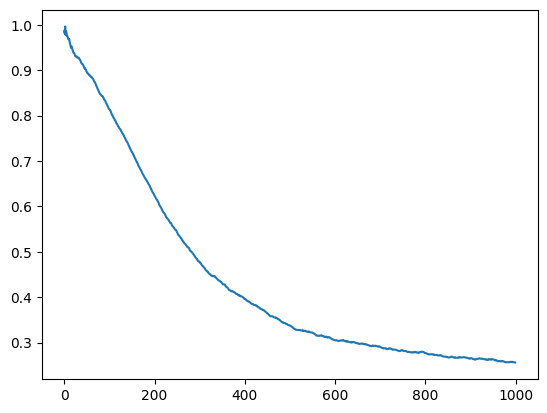

In [212]:
df.ewm(span=100).mean().mean(axis=1).plot()